# Ottimizzazione del traffico

In questo capitolo vado a mostrare gli aspetti di modellazione del sistema, enunciare il problema e gli algoritmi
proposti.

## Introduzione

Il routing in una rete è un’operazione complessa che coinvolge molti attori e protocolli che permettono
l’organizzazione fra tutti questi componenti indipendenti fra di loro. Le ragioni della complessità sono molteplici:

Il routing richiede un grado di coordinazione fra i vai nodi nella rete o nel segmento di rete considerato piuttosto che
solo fra due nodi. Ad esempio pensiamo i protocolli di livello 2 e livello 4.

L’architettura di routing deve risolvere tutti quei casi di guasti e malfunzionamenti dei collegamenti o dei nodi,
redirezionare il traffico ed aggiornare i database informativi di ogni device.

Per ottenere delle performance buone, l’algoritmo di routing può essere costretto a modificare le sue rotte
precedentemente calcolate quando parti o segmenti di rete diventano congestionati.

## Difficoltà e obiettivi nel routing

Le due funzioni principali di un algoritmo di routing sono:

```{margin} Routing table
È la struttura dati che un dispositivo ha al suo interno in cui troviamo una lista di destinatari, la distanza e come
raggiungere quel preciso destinatario ed in più altre informazioni a seconda del protocollo finale
```
1. la selezione delle rotte fra le varie coppie origine destinazione

2. la consegna dei messaggi alla corretta destinazione una volta scelta la rotta

La seconda funzione può sembrare banale una volta usate le routing table. Ciò non è sempre vero, in quanto questo
concetto è molto semplice nel caso che io possa fare *affidamento* sull’infrastruttura di rete. Nel caso in cui questo non
sia vero e quindi io ho a che fare con una infrastruttura non affidabile, diventa fondamentale il modo in cui scelgo il
next-hop ed il modo in cui progetto la rete per la sua robustezza.

```{margin} Next-hop
È il dispositivo successivo rispetto al device sotto esame, all’interno del percorso che unisce topologicamente due
punti di interesse, ad esempio possono essere una coppia origine-destinazione
```

È possibile che 2 scelte diverse di next-hop portino allo stesso destinatario nella topologia, ma supponiamo un next-hop
venga disconnesso poiché il collegamento prescelto non è più disponibile. Nel caso che un collegamento non sia disponibile,
non mi concentro più sulla seconda funzione e sul capire cosa succede, ma mi concentrerò sulla prima funzione e come
influisce sulle performance della rete.

Per quanto riguarda la prima funzione, e cioè la selezione delle rotte corrette dall'origine alla destinazione, osserviamo
che ci sono due metriche principali sulla performance di una rete che sono influenzati dall’algoritmo di routing:

1. Throughput, la quantità di servizio offerta dalla rete

2. Latenza media dei pacchetti, la qualità del servizio offerto dalla rete

Il routing interagisce con il controllo di flusso per determinare queste metriche di performance attraverso un controllo
a catena chiusa.

:::{figure-md} markdown-fig
<img src="https://miro.medium.com/max/1400/1*q_J7uLY97EyiFdYXOXuG0g.png" alt="mcu" class="bg-primary mb-1" width="700px">

Immagine **temporanea**
:::

Una euristica molto efficace nel tentare di mantenere bassa la latenza di percorrenza del sistema all'aumentare del traffico
è la seguente:

> All'aumentare dell'intensità media del carico offerto valuto la latenza media del sistema, quando qusta diventa 
> eccessiva inizio a scartare dei pacchetti

Questo ha come effetto il comportamento secondo cui tanto più l'algoritmo riesce a tenere bassa la latenza e tanto più 
potrà ammettere traffico ed aumentare così il throughput che la rete offre.

Propongo la seguente simulazione:

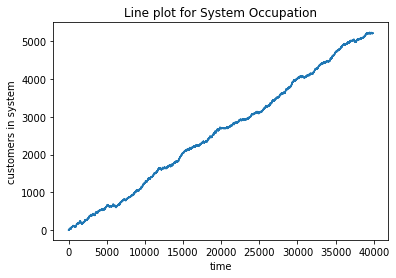

average wait = 262449.288
received: 79703, dropped 247, sent 79703
loss rate: 0.0030990050562714074
average system occupancy: 2600.937


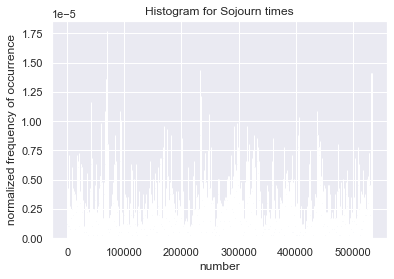

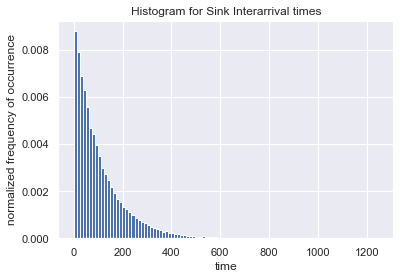

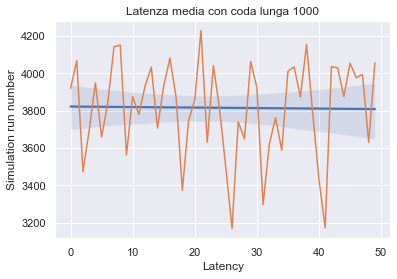

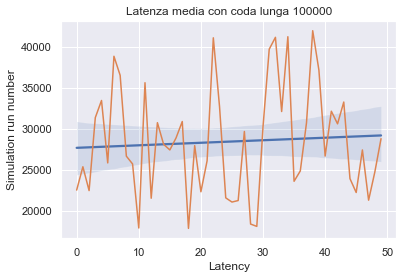

In [1]:
import sys
sys.path.append(r"C:\Users\DULLA\PycharmProjects\Thesis_Data_Analisys\models")
sys.path.append(r"C:\Users\DULLA\PycharmProjects\Thesis_Data_Analisys")
import random
import functools
import seaborn as sns
import simpy
import numpy
import matplotlib.pyplot as plt
import pandas
from models import SimComponents
from SimComponents import PacketGenerator, PacketSink, SwitchPort, PortMonitor
adist = functools.partial(random.expovariate, 0.01)
sdist = functools.partial(random.expovariate, 0.05)  # mean size 100 bytes
samp_dist = functools.partial(random.expovariate, 0.005)
port_rate = 1.5

env = simpy.Environment()  # Create the SimPy environment
# Create the packet generators and sink
ps = PacketSink(env, debug=False, rec_arrivals=True)
pg = PacketGenerator(env, "Greg", adist, sdist)
switch_port = SwitchPort(env, port_rate, qlimit=100000)
# Using a PortMonitor to track queue sizes over time
pm = PortMonitor(env, switch_port, samp_dist)
# Wire packet generators, switch ports, and sinks together
pg.out = switch_port
switch_port.out = ps
# Run it
env.run(until=8000000)
# print("Last 10 waits: " + ", ".join(["{:.3f}".format(x) for x in ps.waits[-10:]]))
# print("Last 10 queue sizes: {}".format(pm.sizes[-1000:]))

fig, axis = plt.subplots()
axis.plot(pm.sizes)
axis.set_title("Line plot for System Occupation")
axis.set_xlabel("time")
axis.set_ylabel("customers in system")
plt.show()
sns.set_theme(style="darkgrid")

# print("Last 10 sink arrival times: " + ", ".join(["{:.3f}".format(x) for x in ps.arrivals[-10:]]))
print("average wait = {:.3f}".format(sum(ps.waits) / len(ps.waits)))
print(
    "received: {}, dropped {}, sent {}".format(switch_port.packets_rec, switch_port.packets_drop, pg.packets_sent))
print("loss rate: {}".format(float(switch_port.packets_drop) / switch_port.packets_rec))
print("average system occupancy: {:.3f}".format(float(sum(pm.sizes)) / len(pm.sizes)))
fig, axis = plt.subplots()
axis.hist(ps.waits, bins=10000, density=True)
axis.set_title("Histogram for Sojourn times")
axis.set_xlabel("number")
axis.set_ylabel("normalized frequency of occurrence")
plt.show()
fig, axis = plt.subplots()
axis.hist(ps.arrivals, bins=100, density=True)
axis.set_title("Histogram for Sink Interarrival times")
axis.set_xlabel("time")
axis.set_ylabel("normalized frequency of occurrence")
plt.show()
i = 0
avgWait = []
del env, ps, pg, pm, switch_port
while i < 50:
    env = simpy.Environment()
    ps = PacketSink(env, debug=False, rec_arrivals=True)
    pg = PacketGenerator(env, "Greg", adist, sdist)
    switch_port = SwitchPort(env, port_rate, qlimit=1000)
    pm = PortMonitor(env, switch_port, samp_dist)
    pg.out = switch_port
    switch_port.out = ps
    env.run(until=800000)
    wait = sum(ps.waits) / len(ps.waits)
    # print("average wait = {:.3f}".format(wait))
    avgWait.append(str(wait))
    del env, ps, pg, pm, switch_port
    i += 1
sns.set()
fig, axes = plt.subplots()
plt.title("Latenza media con coda lunga 1000")
avgWait = numpy.asarray(avgWait, dtype=numpy.single)
df = pandas.DataFrame({"y": avgWait, "x": numpy.asarray(range(len(avgWait)), dtype=numpy.single)})
sns.regplot(x="x", y="y", data=df, scatter=False)
p = sns.lineplot(x="x", y="y", data=df)
p.set(xlabel="Latency", ylabel="Simulation run number")
plt.show()
i = 0
del avgWait, df
# del env, ps, pg, pm, switch_port
avgWait = []
while i < 50:
    env = simpy.Environment()
    ps = PacketSink(env, debug=False, rec_arrivals=True)
    pg = PacketGenerator(env, "Greg", adist, sdist)
    switch_port = SwitchPort(env, port_rate, qlimit=100000)
    pm = PortMonitor(env, switch_port, samp_dist)
    pg.out = switch_port
    switch_port.out = ps
    env.run(until=800000)
    wait = sum(ps.waits) / len(ps.waits)
    # print("average wait = {:.3f}".format(wait))
    avgWait.append(str(wait))
    del env, ps, pg, pm, switch_port
    i += 1
sns.set()
fig, axes = plt.subplots()
avgWait = numpy.asarray(avgWait, dtype=numpy.single)
plt.title("Latenza media con coda lunga 100000")
df = pandas.DataFrame({"y": avgWait, "x": numpy.asarray(range(len(avgWait)), dtype=numpy.single)})
sns.regplot(x="x", y="y", data=df, scatter=False)
p = sns.lineplot(x="x", y="y", data=df)
p.set(xlabel="Latency", ylabel="Simulation run number")
plt.show()


```{note} Distribuzioni atipiche
Nel capitolo successivo sulle distribuzioni stabili vediamo come il traffico sia da trattare in modo
diverso rispetto alla classica elaborazione statistica dei segnali.
```

Da questi grafici vediamo come il segnale poiché distribuito secondo una distribuzione a code pesanti, mostra trend nel
segnale throughput in $\frac{bit}{s}$ anche quando in realtà non abbiamo nessun motivo per crede che ci siano trend nel
throughput in quanto il tasso di arrivi medio è sempre lo stesso... Ripetiamo come queste medie mobili evidenzino dei
trend e correlazioni nei dati anche quando in realtà non ci sono. La presenza di questi trend "fasulli" è una condizione
necessaria, dunque in assenza di ulteriori informazioni al contorno non possiamo diure niente. Nel nostro caso abbiamo
tutte le informazioni e sappiamo che questi trend non sono "reali" ma un effetto della self-similarity del traffico e una
conseguenza dell'uso di un metodo statistico (valido) ma non corretto, in questo caso, come le medie mobili. Nel capitolo
sulle distribuzioni stabili e suelle simulazioni dati approfondiamo la discussione usando altri dataset famosi.

Continuando la discussione della distribuzione statistica del traffico e l'analisi del traffico di controllo possiamo dire
che tutto questo nasce dal fatto che ho fenomeni di ricombinazione complessi ed un tipo di traffico caratterizzato dalla
proprietà di self-similarity. In modo informale possiamo dire che il traffico di controllo (un po' come tutto il traffico
web) sia modellabile con queste distribuzioni particolari poiché è, in generale, caratterizzato da questa sua self-similarity.
Nella pratica, una delle conseguenze più visibili è la disparità fra i vari tipi di flussi.

Un effetto tanto comune quanto problematico di queste proprietà statistiche del traffico e che motiva un'analisi statistica
è che alcuni flussi di pacchetti di lunghezza media piccola, conquistano tutta la banda disponibile. Altri flussi
di lunghezza media dei pacchetti maggiore, invece soffrono di starvation. Per questi motivi ho bisogno di implementare un
controllo della rete. I benefici dell'uso di algoritmi di controllo SDN unito alle tecniche di controllo SDN per la
disseminazione dei risultati e dei comandi, verranno esposti nell'ultimo capitolo che presenta le applicazioni e i
risultati delle simulazioni delle varie applicazioni.

## Efficienza ed equità

Suppondendo che ci sia qualche meccanismo per il controllo del traffico e che quindi le perdite siano trascurabili si ha
che: <br> $ x_n + x_i = c \quad \forall i \in [1 , n-1] $ dunque il throughput
$ \theta = (n-1)(c-x_n) + x_n = c(n-1) - x_n(n-2) $ <br> Dunque una streategia per aumentare il thorughput è quella di
spingere il traffico offerto da $ x_n \rightarrow 0 $, ma questo non è molto equo nei suoi confronti... C'è un altro modo
per garantire un uso completo delle risorse ed equo.

## Allocazione ottima delle risorse

Per ottimizzare l'allocazione delle risorse di rete per tutti gli utenti, possiamo ragionare:
* in termini di ottimizzazione distribuita
* dell'equilibrio di Nash in cui la rete si troverà a regime
* secondo i principi di ottimalità di Wardrop

A questo punto ragionando dell'ottimizzazione distribuita introduco la funzione ulitità $ U_i(x_i) $ che ogni device
produce per ogni info che trasmette. Ciò che voglio è massimizzare l'utilità dell'intero sistema. <br>
$ \displaystyle\max_{x_i \ge 0}\sum_{i \in \overline{S}} U_i(x_i) $. Questo è molto diverso rispetto al concetto di
system optimum descritto da Wardrop.
#### Ipotesi 1
Per ogni $ i \in \overline{S} $, $ U_i(x_i) $ è una funzione monotona crescente, liscia e convessa.

Sia $ x_i^*, i \in \overline{S} $ soluzione ottima del problema. Poiché per ipotesi la funzione è convessa e per le
proprietà del punto ottimo si ha che $\nabla U =0 $ e quindi <br>
$ \displaystyle\sum_{i \in \overline{S}} \nabla U_i(x_i^*)(x_i-x_i^*) \leq 0 $ <br> da questo punto in poi ragiono con
un'analisi del punto fisso $ x_i^* $. Riorganizzo i termini e posso dire: <br>
$ \displaystyle\sum_{i \in \overline{S}} \nabla U_i(x_i^*)x_i^*\frac{x_i-x_i^*}{x_i^*} \leq 0 $ <br> qual'è l'interpretazione
dei termini:
* $ \frac{x_i-x_i^*}{x_i^*} $ è il cambio marginale di rate di trasmissione della sorgente $ i $
* $ \nabla U_i(x_i^*)x_i^* $ può essere interpetato come la *fairness* della sorgente

L'ultima equazione ci dice la somma pesata dei cambi di rate di trasmissione in ogni utente è meno di zero.

### Proportional fairness

Scegliamo per esempio $ U_i(x_i)=w_ilogx_i $ con $ w_i \ge 0 $. La disequazione variazionale diventa: <br>
$ \displaystyle\sum_{i \in \overline{S}} w_i\frac{x_i-x_i^*}{x_i^*} \leq 0 $, dunque le variazioni di rate per ogni
utente pesati per la loro "importanza" sono non positivi.
#### Esempio
Sia data la rete in figura, chiamato anche **modello KP**

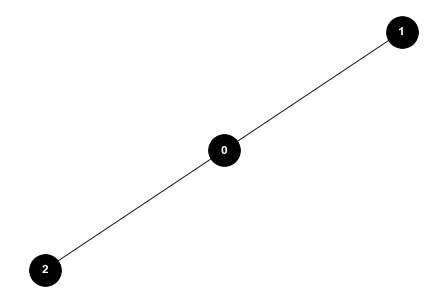

In [2]:
import networkx as nx
G = nx.Graph()
G = nx.Graph()

for i in range(0, 2):
    G.add_node(i)

G.add_edge(0, 1)
G.add_edge(0, 2)
nx.draw(G, with_labels=True, font_weight='bold', node_size=1000, node_color='black', font_color='white')
plt.show()

Supponiamo di usare una allocazione *proporional fair* e cioè
<br> $ U_i= w_ilogx_i $ in cui $ w_i=1 $ $\forall i \in \overline{S}$  il problema diventa
<br>$\displaystyle\max_{\textbf{x}\ge 0} \quad log x_0 +log x_1 + log x_2 $ <br> $\qquad st $ <br> $\qquad$
\begin{equation}
    \begin{cases}
      x_0 + x_1 \leq 2\\
      x_0 + x_2 \leq 1
    \end{cases}\
\end{equation} <br>
Poiché il $\displaystyle \lim_{x\to 0} log x = -\infty $ è chiaro che la politica di allocazione del traffico non potrà
asssegnare zero traffico ad un collegamento. Questo mi permette di considerare i vincoli $ \textbf{x}\ge 0 $ ridondanti.
Dunque volendo risolvere il problema tramite rilassamento lagrangiano posso rilassare i vincoli di capacità ottenendo:
<br> $ \textbf{L}(\textbf{x}, \lambda) = \quad log x_0 +log x_1 + log x_2 -\lambda_A(x_0+x_1)-\lambda_B(x_0+x_2) $ <br>
Ora cerco il punto stazionario ponendo $ \frac{\partial L}{\partial x_i} =0 $ $ \forall i \in \overline{S} $ ottengo:
 <br> $ x_0 = \frac{1}{\lambda_A+\lambda_B} $ , $ x_1 = \frac{1}{\lambda_A} $ , $ x_2 = \frac{1}{\lambda_B} $ <br>
Questo unito al fatto che $ x_0 + x_1 = 2$ e $x_0 + x_2 = 1 $ ottengo <br>  $ \lambda_A = \frac{\sqrt{3}}{\sqrt{3}+1} $ e
$ \lambda_B = \sqrt{3} $
<br> dunque
$\begin{equation}
    \begin{cases}
       x_0^* = \frac{\sqrt{3}+1}{2\sqrt{3}+3} \\
       x_1^* = \frac{\sqrt{3}+1}{\sqrt{3}} \\
       x_2^* = \frac{1}{\sqrt{3}}
    \end{cases}\
\end{equation}$ <br>

C:\Users\DULLA\AppData\Local\Temp\ipykernel_16352\2092273623.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)  # Method 1


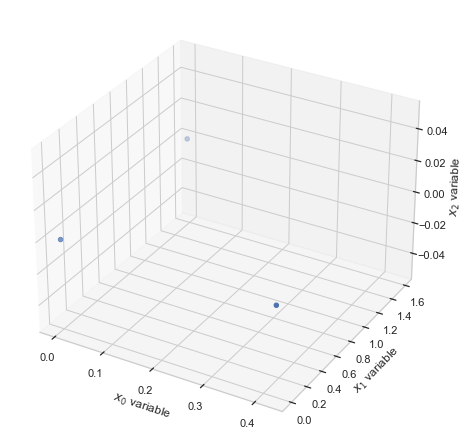

In [3]:
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid", {'axes.grid': False})

fig = plt.figure(figsize=(6, 6))

ax = Axes3D(fig)  # Method 1

x = [0, 0, (np.sqrt(3) + 1) / (3 + 2 * np.sqrt(3))]
y = [0, (np.sqrt(3) + 1) / (np.sqrt(3)), 0]
z = [1 / (np.sqrt(3)), 0, 0]

ax.scatter(x, y, marker='o')
ax.set_xlabel(r'$x_0$ variable')
ax.set_ylabel(r'$x_1$ variable')
ax.set_zlabel(r'$x_2$ variable')

plt.show()

Qui verifico con Wolfram Mathematica che il procedimento sia corretto:

    max{log(x) + log(y) + log(z)|x + y<=1 ∧ x + z<=2}≈-0.954769 at (x, y, z)≈(0.42265, 0.577351, 1.57735)


Più in generale possiamo dire che che usando la disciplina *processor sharing* il tempo di risposta medio del sistema è:
<br> $\frac{\mu}{\mu - \lambda}$ <br>  e normalizzando sul tempo di risposta medio ottengo: $\frac{1}{1 - \rho}$ <br>
Qual è l'effetto di ridurre il tasso di occupazione del sistema? Vediamolo col seguente grafico:

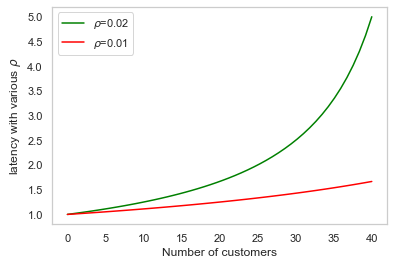

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 40)
y = 1/(1-0.02*x)
y2 = 1/(1-0.01*x)
plt.figure()
plt.plot(x, y, color="green", label=r"$\rho$=0.02")
plt.xlabel('x')
plt.plot(x, y2,color="red", label=r"$\rho$=0.01")
plt.legend()
plt.xlabel('Number of customers')
plt.ylabel(r'latency with various $\rho$')
plt.show()

## Algoritmi per il controllo della congestione

Posso osservare che il problema definito precedentemente è un problema convesso e i vincoli di capacità sono dei vincoli
di simplesso. I vincoli di simplesso li ritroviamo anche nei problemi di ottimizzazione sparsa. Nei problemi di
ottimizzazione sparsa uno dei metodi principali per risolvere questi programmi è l'utilizzo del metodo a *penalty
function*. In pratica invece di considerare i vincoli di capacità come se fossero dei vincoli esterni, io li metto nella
funzione obiettivo attraverso l'uso di una funzione penalità. Se procedo in questo modo ottengo: <br>
$\displaystyle max_{x \ge 0} \sum_{i \in \overline{S}} U_i(x_i) - \sum_{l \in \overline{L}} \int_{0}^{\sum_{i \in S_l} x_i} p_l(x)\,dx $

La funzione $ p_l(x) $ denota il *price* del collegamento, cioè il costo a cui vengo sottoposto per attraversare quel
collegamento e $ c_l $ è la sua capacità. Attenzione per i vincoli di conservazione in una rete di flusso a divergenza
nulla bisogna fare attenzione al fatto che il *price* del link $ l $ è funzione del tasso di arrivo *aggregato* cioè
faccio un taglio attorno al nodo e sommo su tutti i flussi che attraversano quel taglio.

Nel libro di {cite:p}`Srikant` l'autore dimostra come le condizioni necessarie di
ottimalità siano le seguenti: $\displaystyle U_i'(x_i) - \sum_{l \in L_i}p_l(\sum_{r \in S_l}x_r) = 0 $,
$i\in \overline{S} $ Dunque posso creare un algoritmo di controllo con un metodo del gradiente, ottenendo: <br>
$\displaystyle \frac{dx_r}{dt} = k_i(x_i)(U_i'(x_i) - \sum_{l \in L_i}p_l(\sum_{r \in S_l}x_r))_{x_i}^{+} $ ,
$i\in \overline{S} $ il simbolo $ [ \circ ]^{+} $ indica la parte positiva, dunque useremo un gradiente proiettato. Questo
algoritmo sempre nel libro di {cite:p}`Srikant` viene dimostrato come l'obiettivo sia
una funzione di Lyapunov per il sistema, dunque qualunque traiettoria venga indicata dalla soluzione del mio controllore
sarà asintoticamente stabile. Una verisione semplificata ed implementata di questo controllore è l'algoritmo di
{cite:p}`KellyMT98`.

Si può ragionare in modo analogo anche con il problema duale. In questa versione ogni collegamento usa il proprio tasso
di arrivo totale e con quello si calcola il prezzo di sé stesso. Questo algoritmo si può intereptare nel seguente modo:
se il tasso totale di arrivi è superiore alla propria capacità, allora incrementa il proprio prezzo secondo una *barrier*
function opportuna, altrimenti decrementa il prezzo. Perché parlare di algoritmi di ottimizzazione duali e primali nel
contesto delle reti? Perché è giusto capire con che logica funzionano gli algoritmi ad oggi usati per la gestione delle
congestioni e del flusso. In modo approssimato si possono classificare in 2 categorie:
* A livello di trasporto come nel TCP NewReno oppure Vegas i quali basano il traffico offerto su dei feedback disponibili
* A livello di rete attraverso meccanismi impliciti come AQM DropTail o RED

In prima approssimazione possiamo dire come l'algoritmo primale ha una legge dinamica per gestire il tasso di invio dalla
sorgente ed una legge statica per generare il prezzo del collegamento, un po' come in TCP. Dall'altra parte possiamo dire
che il problema duale usa una legge statica per gestire il tasso di invio della sorgente ed una legge dinamica
(tempovariante) per assegnare il *price* al collegamento, similmente a come lavora AQM. Giusto per fare un esempio: nei
meccanismi di AQM il prezzo ombra (il *price*) è il $ p_l $ e nel metodo di Floyd e Jacobson la lunghezza della coda viene
usata come stimatore del tasso di congestione del collegamento. In quel caso uso la versione duale dell'algoritmo per
aggiustae il prezzo del collegamento.

Il problema di questi metodi è che sono computazionalmente molto dispensiosi, questo a causa del calcolo all'interno
dell'algoritmo (vedi *steepset descent* nel metodo primale) oppure per il calcolo di uno stimatore per la congestione in
un collegamento (vedi lo stimatore empirico lunghezza del buffer nel AQM).

## Algoritmi centralizzati: metodi SDN

Adesso ci concentriamo su gli algoritmi centralizzati. Questi metodi possono essere di due tipi:
* Centralizzati eseguiti su ogni device (ad esempio Djikstra con OSPF) ogni device manda in flooding *tutto*
* Centralizzati su un unico device, oggetto di questo paragrafo

Un'ultima postilla che faccio sul primo punto è la seguente osservazione: l'algoritmo OSPF con Djikstra è un ottimo
algoritmo di label correcting. Ha una debolezza: ogni device ha bisogno dell'*intera* topologia e quindi ogni device
deve trasmettere un LSA (link state advertisement) in ogni singolo collegamento non bloccato con STP. Ho quindi un numero
di pacchetti che nel peggiore dei casi sarà $ o(n^2) $. Dunque OSPF è il miglior algoritmo che abbiamo a disposizione ma
è molto pesante...